# Continuous data

This notebooks illustrates how to use the HSIC lasso algorithm on continuous data, as features or target data.

In [1]:
from pathlib import Path

import h5py
import numpy as np
import matplotlib.pyplot as plt

from hsic_optimization.hsic_tools import generate
from hsic_optimization.hsic_lasso import (
    cd_hsic_lasso,
    feature_vanilla,
    vanilla_hsic_lasso,
)

## Dataset and parameter generation

We generate a small dataset to demonstrate the method.

In [2]:
n_samples = 1_000
n_features = 200
n_active = 10
dset_file = Path(f"../data/test_dataset_{n_features}_by_{n_samples}_continous.h5")

In [3]:
if not dset_file.exists():
    generate(
        dset_file,
        samples=n_samples,
        feats=n_features,
        active=n_active,
        seed=1234,
        continuous_features=True,
        continuous_target=True,
    )

In [4]:
with h5py.File(dset_file, "r") as fd:
    Y = np.array(fd["Y"])
    X = np.array(fd["X"])

## HSIC Lasso model fit

In [5]:
block_size = 20
n_repeats = 3

In [6]:
%%time
path_cd, beta_cd, lams_cd = cd_hsic_lasso(
    X,
    Y,
    B=block_size,
    M=n_repeats,
    num_feat=n_active,
    feature=feature_vanilla,
    y_kernel="Gaussian",
)
path_cd = path_cd.toarray()

CPU times: user 49.1 s, sys: 0 ns, total: 49.1 s
Wall time: 49.1 s


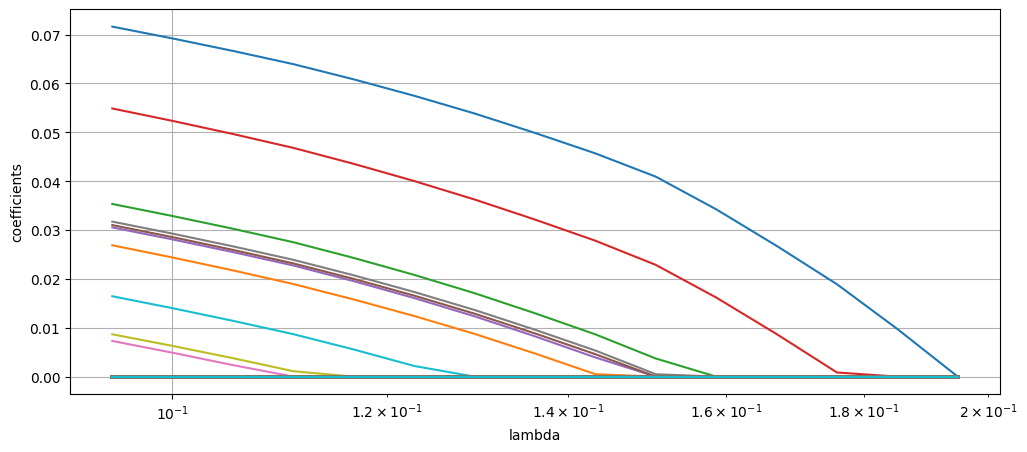

In [7]:
_, ax = plt.subplots(figsize=(12, 5))
ax.plot(lams_cd, path_cd)
ax.set_xlabel("lambda")
ax.set_ylabel("coefficients")
ax.set_xscale("log")
ax.grid()

In [8]:
%%time
path, beta, A, lams = vanilla_hsic_lasso(
    X, Y, block_size, n_repeats, n_active, y_kernel="Gaussian"
)
beta = beta.squeeze()

CPU times: user 429 ms, sys: 365 ms, total: 793 ms
Wall time: 15.8 s


In [9]:
abs_errors = np.abs(beta - beta_cd)
rel_errors = abs_errors[beta != 0] / np.abs(beta[beta != 0])

print(f"Max absolute error: {abs_errors.max()}.")
print(f"Max relative error (where beta ≠ 0): {rel_errors.max()}.")

Max absolute error: 0.00010058656334877014.
Max relative error (where beta ≠ 0): 0.012855048291385174.


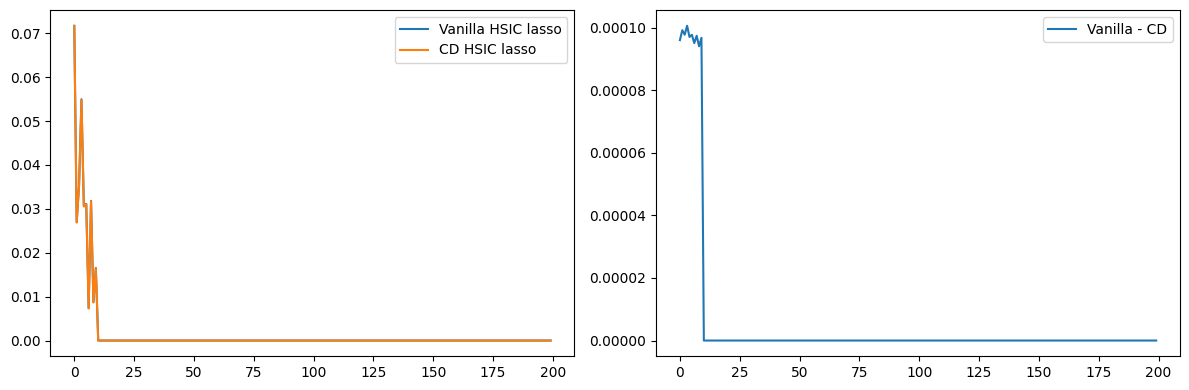

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(beta.ravel(), label="Vanilla HSIC lasso")
axes[0].plot(beta_cd, label="CD HSIC lasso")
axes[0].legend()

axes[1].plot(beta.ravel() - beta_cd, label="Vanilla - CD")
axes[1].legend()

fig.tight_layout()